<a href="https://colab.research.google.com/github/tanvirtaher32/Sarcasm-Detection/blob/main/BiLSTM_emoji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 67)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 67, 200)      5952200     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          135680      ['embedding[0][0]']              
                                                                                              

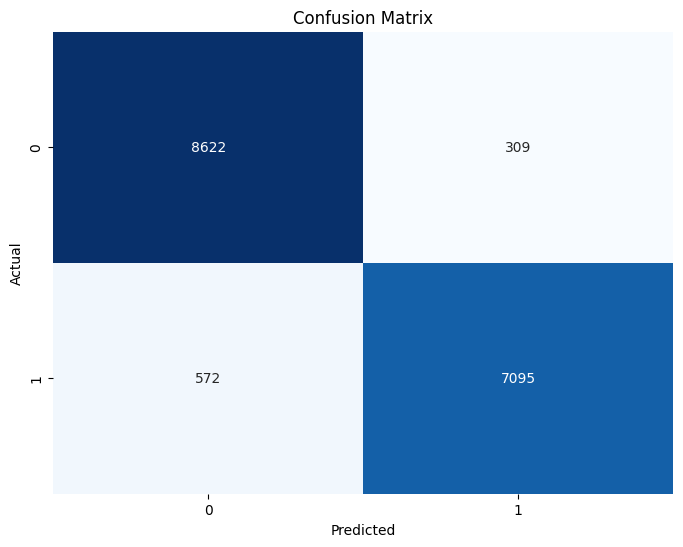

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      8931
           1       0.96      0.93      0.94      7667

    accuracy                           0.95     16598
   macro avg       0.95      0.95      0.95     16598
weighted avg       0.95      0.95      0.95     16598



In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Input, concatenate, Bidirectional, Dropout
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras as keras
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Load the dataset
data_1 = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data = pd.concat([data_1, data_2])

def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x: x[0] != '@', text.split()))

    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

def extract_emoticon_count(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    return len(emoticons)

def preprocess_data(df):
    df['clean_text'] = df['headline'].apply(clean_text)
    df['emoticon_count'] = df['headline'].apply(extract_emoticon_count)
    return df

data = preprocess_data(data)

validation_split = 0.3
max_length = 67

# Tokenize text
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(data['clean_text'])
sequences = tokenizer_obj.texts_to_sequences(data['clean_text'])

# Pad sequences
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment = data['is_sarcastic'].values
emoticon_count = data['emoticon_count'].values

# Shuffle and split data
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]
emoticon_count = emoticon_count[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
emoticon_count_train = emoticon_count[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]
emoticon_count_test = emoticon_count[-num_validation_samples:]

# Define embedding layer
embedding_dim = 200
embedding_matrix = np.random.random((len(tokenizer_obj.word_index) + 1, embedding_dim))

# Define model inputs
text_input = Input(shape=(max_length,))
text_embed = Embedding(len(tokenizer_obj.word_index) + 1, embedding_dim,
                       embeddings_initializer=Constant(embedding_matrix),
                       input_length=max_length,
                       trainable=True)(text_input)
text_bilstm = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.25))(text_embed)

emoticon_input = Input(shape=(1,))
emoticon_dense = Dense(16)(emoticon_input)

# Merge inputs
merged = concatenate([text_bilstm, emoticon_dense])
merged_dense = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged_dense)

# Define and compile the model
model = Model(inputs=[text_input, emoticon_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Define callbacks
checkpoint = ModelCheckpoint("sarcasm_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=3)

# Train the model
history = model.fit([X_train_pad, emoticon_count_train], y_train, batch_size=32, epochs=10,
                    validation_data=([X_test_pad, emoticon_count_test], y_test),
                    callbacks=[checkpoint, early_stopping], verbose=2)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict([X_test_pad, emoticon_count_test])
y_pred = (y_pred > 0.5)  # Convert probabilities to binary predictions

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(class_report)


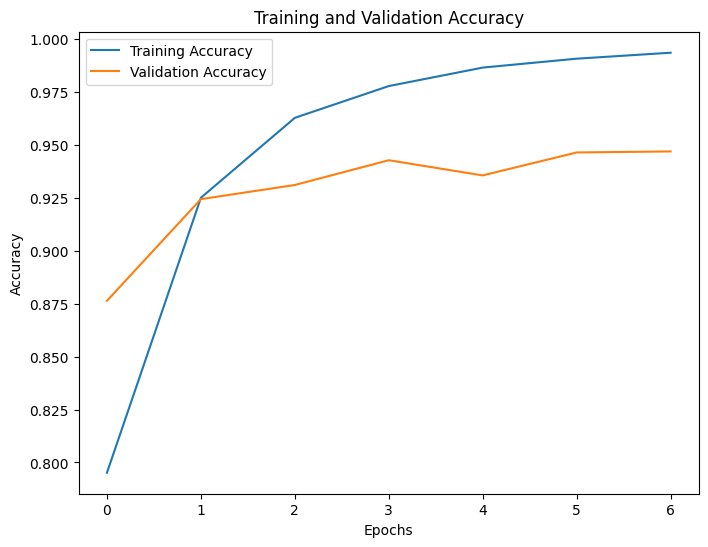

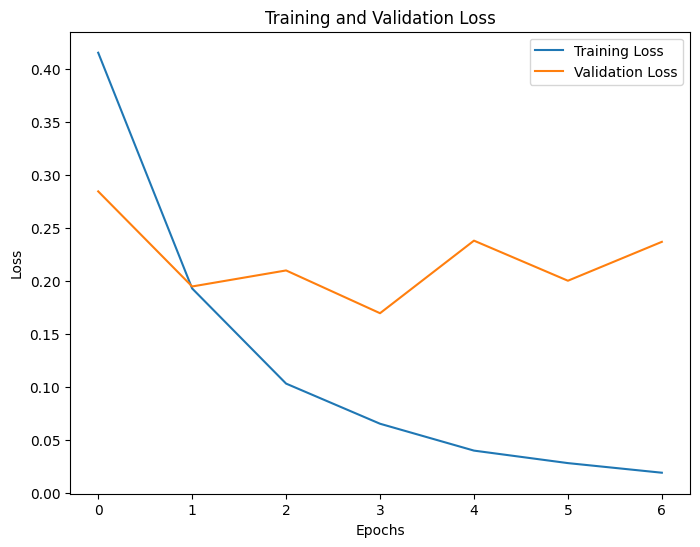

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
